# Import Data

In [1]:
#load npy files
import numpy as np
import gc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#load the data
augmented_no = np.load('../00_data/augumented/augmented_no.npy')
augmented_sphere = np.load('../00_data/augumented/augmented_sphere.npy')
augmented_vort = np.load('../00_data/augumented/augmented_vort.npy')


In [3]:
augmented_no.shape

(50000, 150, 150)

In [4]:
#make y classes for the data
y_no = np.zeros((augmented_no.shape[0],1))
y_sphere = np.ones((augmented_sphere.shape[0],1))
y_vort = np.full((augmented_vort.shape[0],1),2)

In [5]:
from tensorflow.keras.utils import to_categorical
y_no = to_categorical(y_no, num_classes=3)
y_sphere = to_categorical(y_sphere, num_classes=3)
y_vort = to_categorical(y_vort, num_classes=3)

2024-03-28 03:10:12.941868: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 03:10:13.361549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 03:10:14.245504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
#append the x data and y data

x_data = np.concatenate((augmented_no, augmented_sphere, augmented_vort), axis=0)
y_data = np.concatenate((y_no, y_sphere, y_vort), axis=0)


In [7]:
del(augmented_no, augmented_sphere, augmented_vort, y_no, y_sphere, y_vort)

gc.collect()

0

In [8]:
#convert x_data to float32 
x_data = x_data.astype('float32')

gc.collect()

0

In [9]:
x_data[0].max()

0.9765219

# Image Visualization

In [10]:
def apply_preprocessing(image, preprocessing_functions):
    """
    Apply a list of preprocessing functions to an image.
    
    Parameters:
    - image: The input image.
    - preprocessing_functions: A list of functions that take an image as input and return a processed image.
    
    Returns:
    - Processed image.
    """
    for function in preprocessing_functions:
        image = function(image)
    return image

def plot_image_grid(no_subhalo_indices, sphere_subhalo_indices, vort_subhalo_indices, preprocessing_functions=[]):
    fig, axes = plt.subplots(3, len(no_subhalo_indices), figsize=(len(no_subhalo_indices)*5, 5*3))
    for row, indices in enumerate([no_subhalo_indices, sphere_subhalo_indices, vort_subhalo_indices]):
        for i, idx in enumerate(indices):
            processed_image = apply_preprocessing(x_data[idx], preprocessing_functions)
            sns.heatmap(processed_image, ax=axes[row, i], cbar=False, cmap='inferno')
            if row == 0:
                axes[row, i].set_title(f"No Subhalo {idx}")
            elif row == 1:
                axes[row, i].set_title(f"Sphere Subhalo {idx}")
            else:
                axes[row, i].set_title(f"Vort Subhalo {idx}")
            axes[row, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [11]:
base_no = np.array([0,1,2,3,4,5])*10
no_subhalo = base_no
sphere_subhalo = base_no +50000
vort_subhalo = base_no +100000

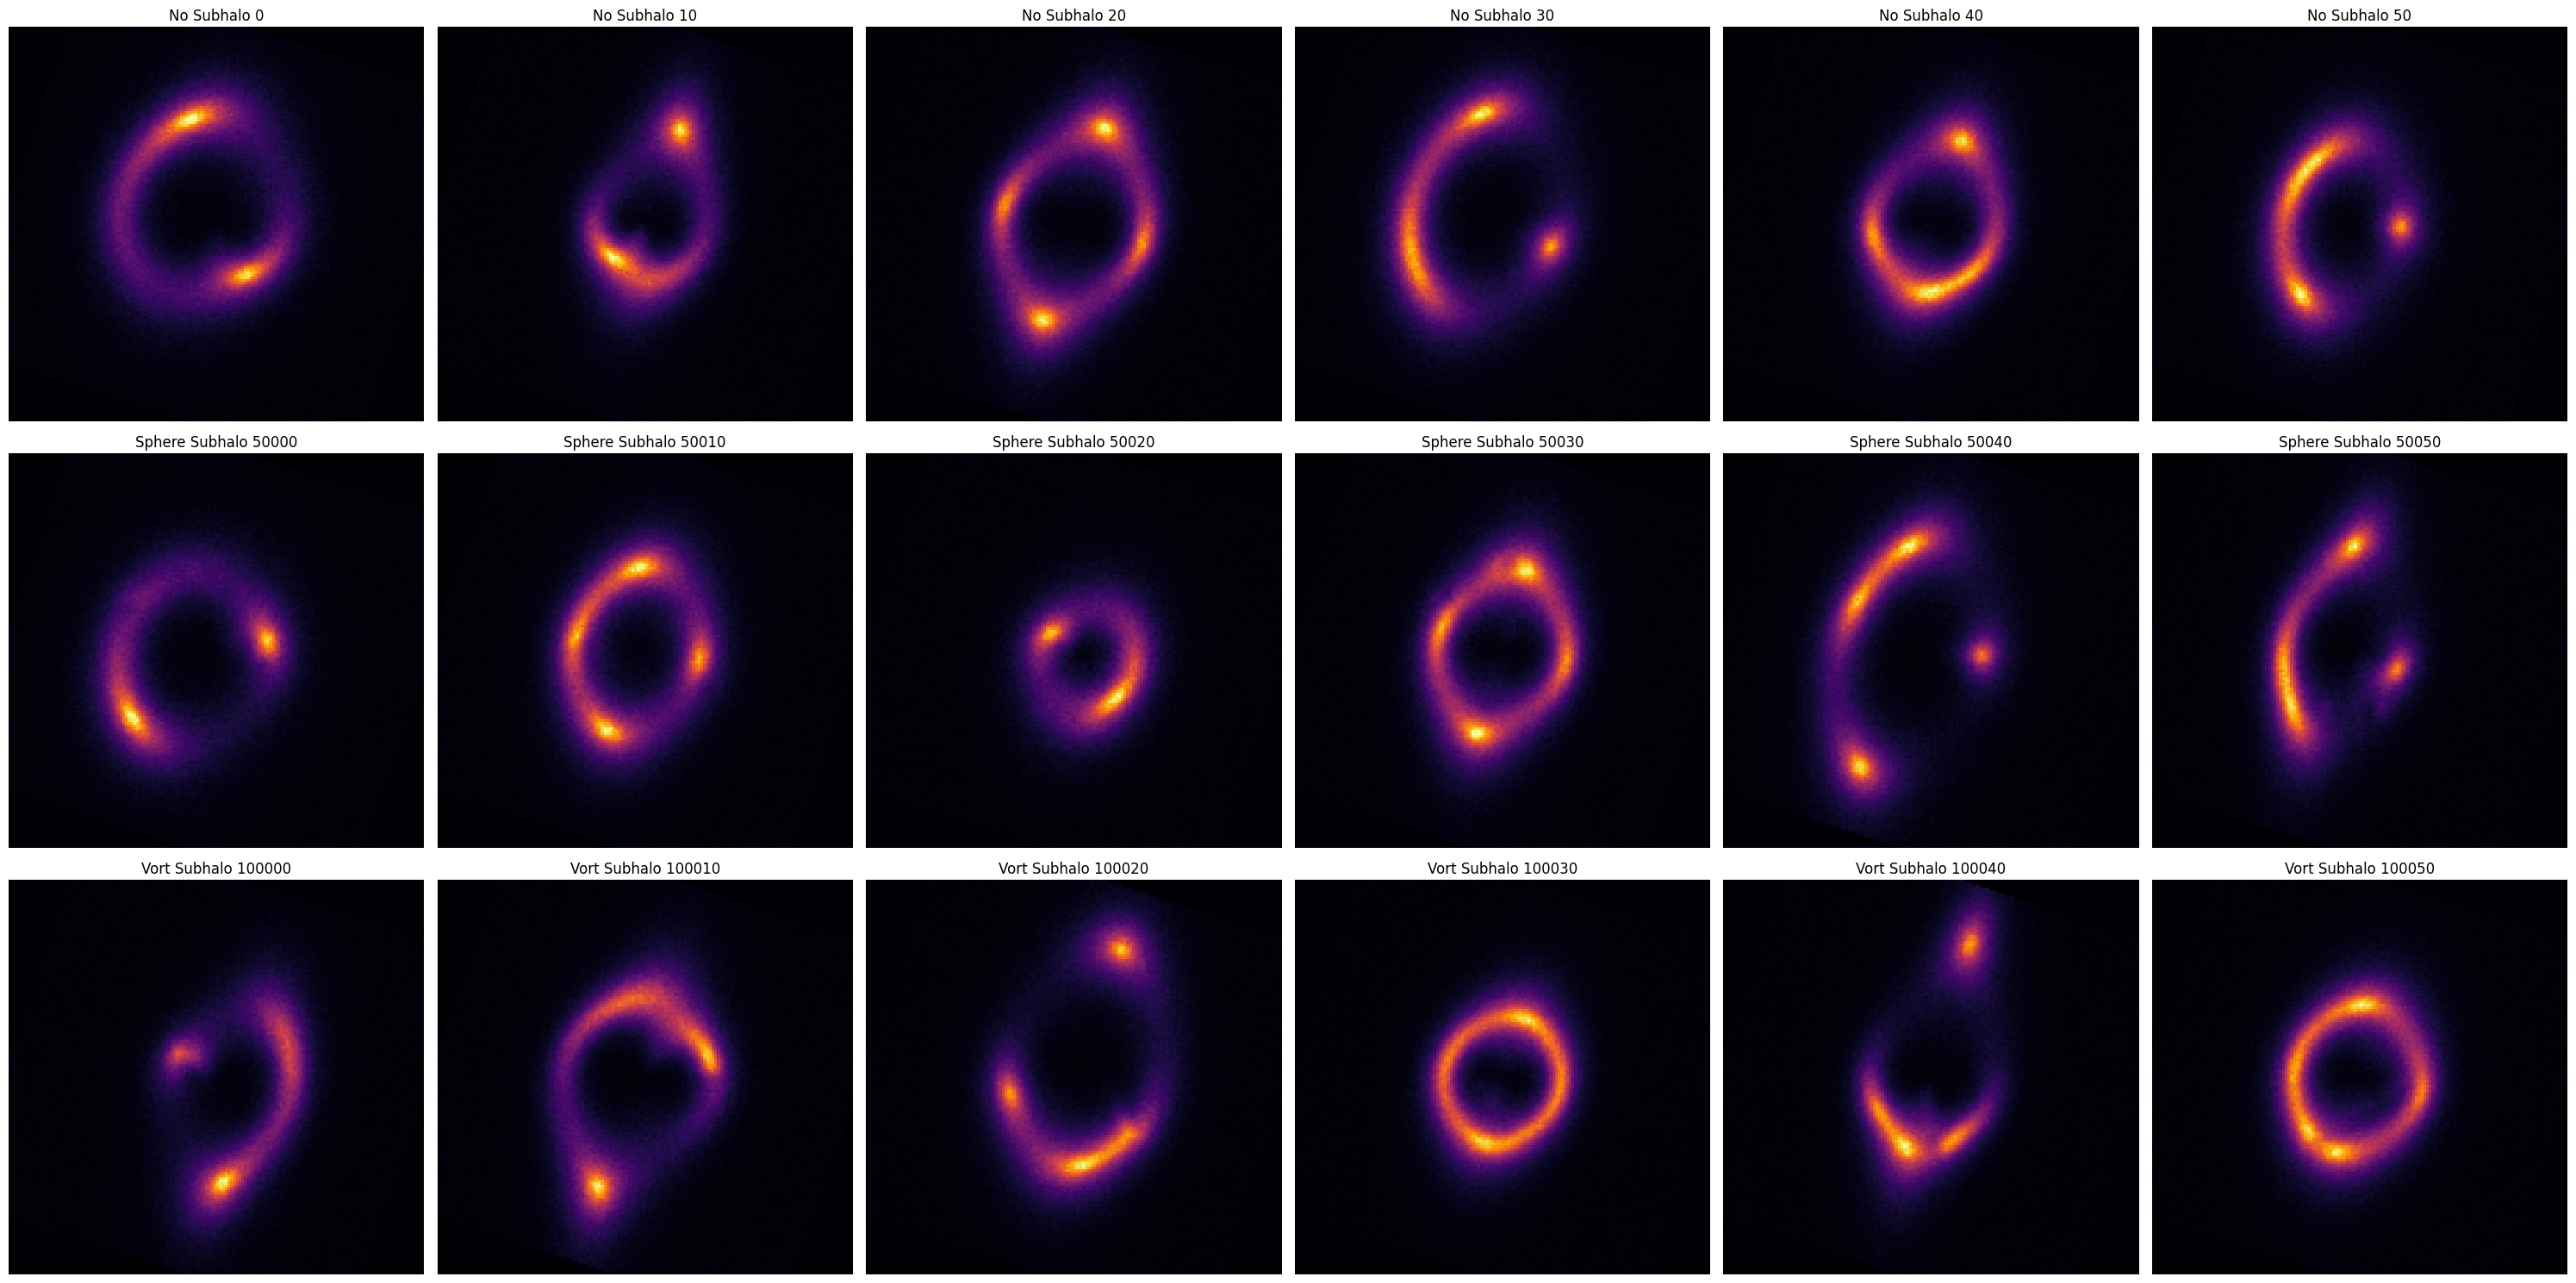

In [12]:
# Example usage
plot_image_grid(no_subhalo, sphere_subhalo, vort_subhalo)

In [9]:
x_data.shape

(150000, 150, 150)

# Train test split 

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [11]:
del(x_data, y_data)
gc.collect()

0

# Model Training

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the number of classes in your dataset
num_classes = 3  # Update this to the number of classes in your dataset

def build_resnet50_model(input_shape=(150, 150, 1), num_classes=num_classes):
    # Initialize the ResNet50 model without pre-trained weights and with the specified input shape
    base_model = tf.keras.applications.ResNet101V2(include_top=False,
                                                 weights=None,  # No pre-trained weights
                                                 input_shape=input_shape)

    # Since we're training from scratch, all layers can be trainable
    base_model.trainable = True

    # Create a new model on top
    inputs = tf.keras.Input(shape=input_shape)
    # Use the generated model
    x = base_model(inputs, training=True)  # Set training=True to ensure BN layers adapt
    
    # Add pooling layer or flatten layer
    x = layers.GlobalAveragePooling2D()(x)
    # Add a dropout layer for some regularization
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    # Add final dense layer with softmax for classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model 

# Build the model
model = build_resnet50_model(input_shape=(150, 150, 1), num_classes=num_classes)

# Print the model summary to check the final architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101v2 (Functional)        │ (None, 5, 5, 2048)     │    42,620,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,882,947 (163.59 MB)

 Trainable params: 42,785,283 (163.21 MB)

 Non-trainable params: 97,664 (381.50 KB)

In [15]:
for i in range(10):
    model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_test, y_test))
    model.save(f'../04_Data_Models/doubleresnet/resnet50_dual_model.h5')
    with open(f'../04_Data_Models/doubleresnet/status.txt', '+a') as f:
        f.write(f'Epoch {i} done')
    gc.collect()


Epoch 1/50


I0000 00:00:1711562518.513426    7975 service.cc:145] XLA service 0x7fdbe0013290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711562518.513468    7975 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-03-27 18:01:58.948618: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-27 18:02:00.655116: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1711562531.355105    7975 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7498/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3338 - loss: 1.1474